# Introduction
To attract more drivers during peak hours, it would be beneficial to taxi companies to predict the amount of taxi orders one hour in advance. I will train models for such a prediction, and I will compare them to one another according to root of mean square error. 

##### Data description
The taxi table consists of two columns:
- datetime: Ranges from the beginning of March 2018 to the end of August.
- num_orders: The amount of taxis ordered since the last observation. This is our target column.

### Initialising

In [47]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from statsmodels.tsa import seasonal as sea #seasonal_decompose
import joblib as jbl


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #boxplot
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()


from sklearn import model_selection as sel, metrics as met, preprocessing as pro
from sklearn import dummy as dum, multioutput as mul
from sklearn import svm, tree, ensemble as ens, linear_model as lin
import lightgbm as lgb


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore") 

#####  Defining Functions

In [2]:
def rmse(y_true, y_pred):
    return met.mean_squared_error(y_true, y_pred)**0.5

##### Loading Datasets

In [3]:
try:
    taxi = pd.read_csv('Downloads/taxi.csv',parse_dates=['datetime'])
except:
    taxi = pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'])


##### A Look at the Datasets

In [4]:
taxi = taxi.set_index('datetime')
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Observations have been recorded every 10 minutes, but for this task we will need hourly predictions.

It's worth checking whether all observations are in order.

In [5]:
taxi.index.is_monotonic_increasing

True

The datetime index is in chronological order.

### Preprocessing
I will resample so that observations will be hourly.

In [6]:
data = taxi.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


The change appears successful. I will compare descriptive values between the original data and the changed data to make sure of that.

In [7]:
taxi.min(), taxi.median(), taxi.mean(), taxi.max()

(num_orders    0
 dtype: int64,
 num_orders    13.0
 dtype: float64,
 num_orders    14.070463
 dtype: float64,
 num_orders    119
 dtype: int64)

In [8]:
data.min(), data.median(), data.mean(), data.max()

(num_orders    0
 dtype: int64,
 num_orders    78.0
 dtype: float64,
 num_orders    84.422781
 dtype: float64,
 num_orders    462
 dtype: int64)

Data seems successfully resampled.

### Exploratory Analysis

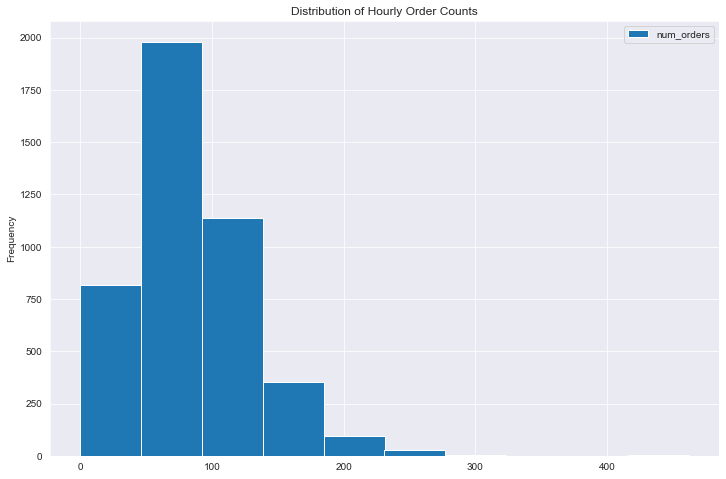

In [9]:
data.plot(figsize = (12,8), kind = 'hist', title = 'Distribution of Hourly Order Counts')
plt.show()

As reflected by the median before, on most hours, fewer than 100 orders are recieved. Over the observed months, rarely had more than 300 taxis been ordered in one hour.

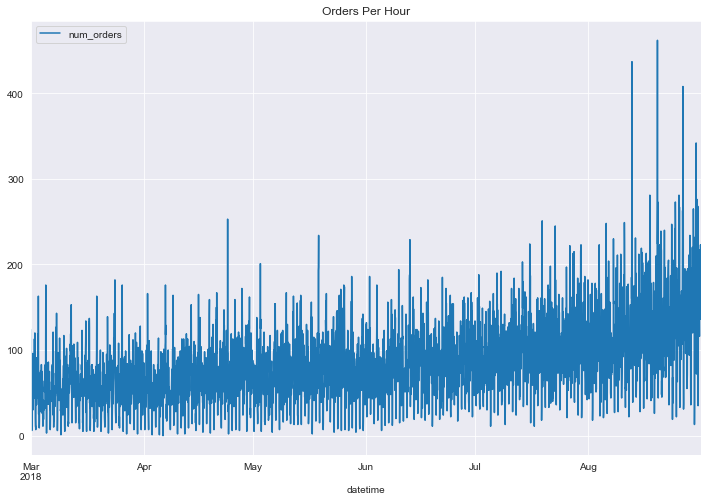

In [10]:
data.plot(figsize = (12,8), title = 'Orders Per Hour')
plt.show()

There is a general trend visible, a rise in amounts as the year progressed, but it's hard to say with such fluctuations. Luckily, the statsmodels library has tools to extract patterns from the chaos.

In [11]:
result = sea.seasonal_decompose(data)
trend = result.trend
seaso = result.seasonal
resid = result.resid
origi = result.observed


The function seasonal_decompose recieves a time series and from it extracts the repeating patterns, also known as seasonality, and the non-repeating patterns, known as trends, and also calculates the residual remaining between the functions it found and the observed data.

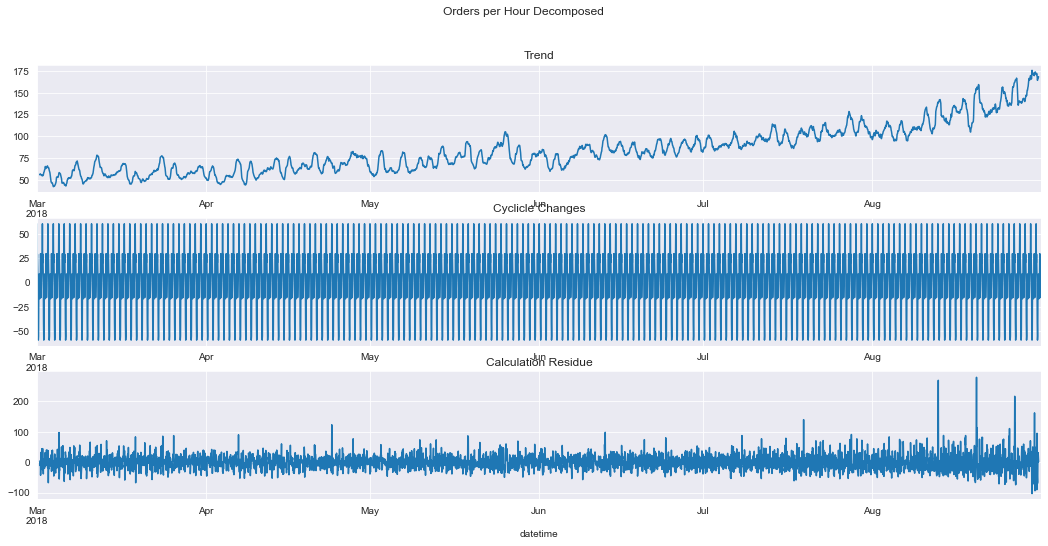

In [12]:
plt.suptitle('Orders per Hour Decomposed')
plt.subplot(311).set_title('Trend')
trend.plot(figsize = (18,8))
plt.subplot(312).set_title('Cyclicle Changes')
seaso.plot()
plt.subplot(313).set_title('Calculation Residue')
resid.plot()
plt.show()

The trend of growth from April to the end of August is more visible when looking at decomposed data. It's worth noting that in every month there are plenty minor trend peaks, around two every week.

Seasonality and residual are hardly discernible this way, though it is worth noting that there are some especially large residual values during august.

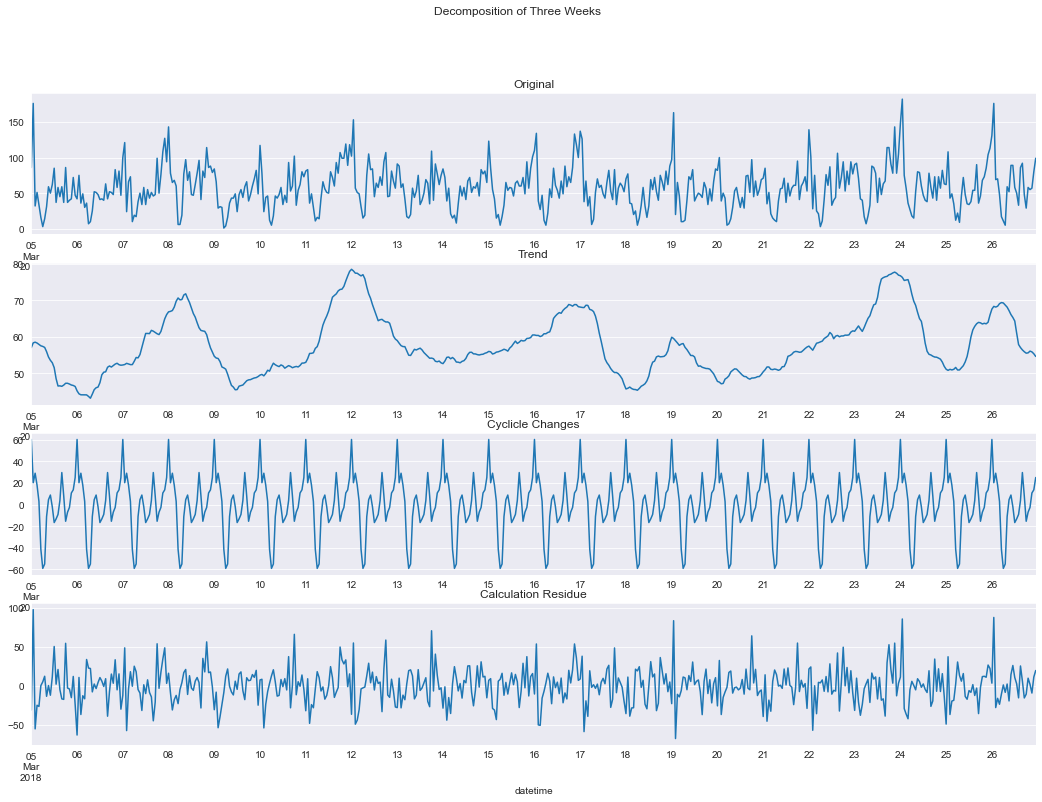

In [13]:
plt.suptitle('Decomposition of Three Weeks')

plt.subplot(411).set_title('Original')
origi['2018-03-05':'2018-03-26'].plot(figsize = (18,12))

plt.subplot(412).set_title('Trend')
trend['2018-03-05':'2018-03-26'].plot()

plt.subplot(413).set_title('Cyclicle Changes')
seaso['2018-03-05':'2018-03-26'].plot()

plt.subplot(414).set_title('Calculation Residue')
resid['2018-03-05':'2018-03-26'].plot()
plt.show()

Seasonality is daily, while trends last between one day and multiple days.

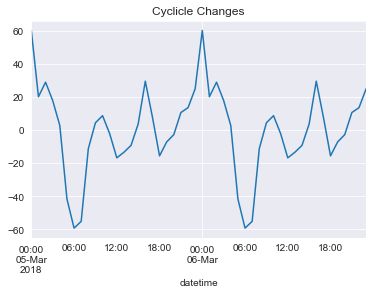

In [14]:

plt.title('Cyclicle Changes')
seaso['2018-03-05':'2018-03-06'].plot()

plt.show()

Seasonality ranges from -60 to 60. Taxi order counts are at their highest at midnight, and at their lowest at six in the morning.

In [15]:
df = data.reset_index()
df

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


Now that the datetime index is a column, features can be extracted from it. 

### Features and Target Preperation
Our target is the num_orders column, in which is the number of orders made during each hour.

As for the features, different elements of the date and time are related to our target in different ways:
- The hour in the day is related to the cyclical changes in the target. It is not a linear relation: a rise in hour does not necessitate a rise in orders, neither does it necessitate a drop in orders.
- The day itself is related to trends, and like the time of day, the connection is not linear but still important. The day can be derived from the data through either the day of the month or the day of the week. I believe two Fridays have more in common with one another than two days that are 5th within their months, since the day of week is related to the routine of all employed people. This as well is not quite a linear connection, as seen in the trend graph.
- The time of year is also essential, and it can be derived from either month or week. Having the week of year as one of the features will complement the day-of-week feature in enabling restoration of the original data from the features. It will also give more precise data on holidays and seasons than the month would.
- Since we are predicting one hour ahead of time, the target of the hour before our prediction will be available in the the data when the model will be in use, so it can be used as a feature. I also shows an image of the present for every future the model is trying to predict, which will be beneicial.
- The number of taxis ordered on the same hour the day before is also closely related to what should be expected from a predicted hour.
- The year column will be a column of unities to our model, it will not be beneficial to its learning process for the given data.

To summarise, the features I will be working with will be hour, day of week, week of year, the number of orders in the previous hour and the number of orders made on the same hour the day before.

In [16]:
df['week'] = df.datetime.dt.isocalendar().week
df['weekday'] = df.datetime.dt.weekday
df['hour'] = df.datetime.dt.hour
df['lasthour'] = df.num_orders.shift(1)
df['yesterday'] = df.num_orders.shift(24)
df

,datetime,num_orders,week,weekday,hour,lasthour,yesterday
0,2018-03-01 00:00:00,124,9,3,0,NaN,NaN
1,2018-03-01 01:00:00,85,9,3,1,124.0,NaN
2,2018-03-01 02:00:00,71,9,3,2,85.0,NaN
3,2018-03-01 03:00:00,66,9,3,3,71.0,NaN
4,2018-03-01 04:00:00,43,9,3,4,66.0,NaN
...,...,...,...,...,...,...,...
4411,2018-08-31 19:00:00,136,35,4,19,207.0,72.0
4412,2018-08-31 20:00:00,154,35,4,20,136.0,142.0
4413,2018-08-31 21:00:00,159,35,4,21,154.0,198.0
4414,2018-08-31 22:00:00,223,35,4,22,159.0,158.0


The new features have been successfully created. As expected, the columns for the previous hour and for the same hour the previous day have null values in the first rows.

In [17]:
df.describe(datetime_is_numeric = True)

,datetime,num_orders,week,weekday,hour,lasthour,yesterday
count,4416,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4392.000000
mean,2018-05-31 23:30:00,84.422781,22.070652,3.005435,11.50000,84.395470,83.969262
min,2018-03-01 00:00:00,0.000000,9.000000,0.000000,0.00000,0.000000,0.000000
25%,2018-04-15 23:45:00,54.000000,15.750000,1.000000,5.75000,54.000000,54.000000
50%,2018-05-31 23:30:00,78.000000,22.000000,3.000000,11.50000,78.000000,78.000000
75%,2018-07-16 23:15:00,107.000000,29.000000,5.000000,17.25000,107.000000,107.000000
max,2018-08-31 23:00:00,462.000000,35.000000,6.000000,23.00000,462.000000,462.000000
std,NaN,45.023853,7.598086,1.990684,6.92297,44.992356,44.498432


Turns out March to August range from week 9 to week 35.

The columns lasthour, yesterday and num_orders all have very similar qualities, since they are all essentially the same column with only a shift to differentiate them.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    4416 non-null   datetime64[ns]
 1   num_orders  4416 non-null   int64         
 2   week        4416 non-null   UInt32        
 3   weekday     4416 non-null   int64         
 4   hour        4416 non-null   int64         
 5   lasthour    4415 non-null   float64       
 6   yesterday   4392 non-null   float64       
dtypes: UInt32(1), datetime64[ns](1), float64(2), int64(3)
memory usage: 228.7 KB


The only null values are the ones caused by the shifts. Their rows only comprise of 0.5% of the data, which is a neglectible quantity.

In [19]:
df = df.dropna().reset_index(drop = True)
x = df.drop(['datetime', 'num_orders'], axis = 1)
y = df.num_orders
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       4392 non-null   UInt32 
 1   weekday    4392 non-null   int64  
 2   hour       4392 non-null   int64  
 3   lasthour   4392 non-null   float64
 4   yesterday  4392 non-null   float64
dtypes: UInt32(1), float64(2), int64(2)
memory usage: 158.8 KB


I dropped the datetime column because many models can't be trained with that data type. Also, the other features make it possible to reconstruct that column entirely, provided the information that it is from 2018.

In [20]:
x_train, x_test, y_train, y_test = sel.train_test_split(x, y, shuffle = False, test_size = 439)


Our features are entirely numeric, and yet they are not fit for linear models. That is because features 'week', 'weekday' and 'hour' are essentially numeric representations of categorical values. Hours of the day and days of the week can't truly be compared to one another. This is why I will only be using tree based models.

##### Hyperparameter Tuning
To determine the best hyperparameters for each model I will use sklearn's GridSearchCV, that will performs cross validation on the training data with variations on hyperparameters to find those that deliver the best results.
- For DecisionTreeRegressor I will try different limitations on tree depth and different minimum thresholds for a split in a tree.
- For RandomForestRegressor I will try different limitations on tree depth and different quantities of estimators. I will test tree depths only up to a lower threshold, keeping the individual trees within the forest relatively simple.
- For GradientBoostingRegressor (which is also tree based) I try different quantities of estimators and different learning rates.

All models will be trained with random_state = 42 for reproduceability.

In [21]:
%%time

tree_grid = dict(max_depth = list(range(3,60)), min_samples_split = list(range(2,10)), 
                 random_state = [42])
model = tree.DecisionTreeRegressor()
tree_cv = sel.GridSearchCV(model, tree_grid, scoring = 'neg_root_mean_squared_error')
tree_cv = tree_cv.fit(x_train, y_train)

Wall time: 19.6 s


In the previous cell, GridSearchCV tested 456 variations of DecisionTreeRegressor hyperparameters.

In [22]:
%%time

forest_grid = dict(max_depth = list(range(3,20)), n_estimators = list(range(50,501,50)), 
                   random_state = [42])
model = ens.RandomForestRegressor()
for_cv = sel.GridSearchCV(model, forest_grid, scoring = 'neg_root_mean_squared_error')
for_cv = for_cv.fit(x_train, y_train)

Wall time: 14min 34s


In the previous cell 170 variations of a RandomForestRegressor's hyperparameters have been tested, containing increasing quantities of simple decision trees inside.

In [23]:
%%time

boost_grid = dict(n_estimators = list(range(50,501,50)), 
                  learning_rate = list(np.arange(0.05, 1.05, 0.05)),
                  random_state = [42])
model = ens.GradientBoostingRegressor()
boo_cv = sel.GridSearchCV(model, boost_grid, scoring = 'neg_root_mean_squared_error')
boo_cv = boo_cv.fit(x_train, y_train)

Wall time: 6min 27s


In the previous cell 200 variations of GradientBoostingRegressor have been tested, containing increasing quantities of simple decision trees.

In [24]:
print('Best gradient boosting hyperparameters:', boo_cv.best_params_,
     '\nBest random forest hyperparameters:', for_cv.best_params_,
     '\nBest decision tree hyperparameters:', tree_cv.best_params_,)

Best gradient boosting hyperparameters: {'learning_rate': 0.05, 'n_estimators': 500, 'random_state': 42} 
Best random forest hyperparameters: {'max_depth': 17, 'n_estimators': 300, 'random_state': 42} 
Best decision tree hyperparameters: {'max_depth': 7, 'min_samples_split': 8, 'random_state': 42}


The best hyperparameters for each model have been successfully found.

Now it is time to select a final model.

In [25]:
boost = ens.GradientBoostingRegressor(random_state = 42, learning_rate = 0.05,
                                     n_estimators = 500)
boost.fit(x_train, y_train)
boo_test = boost.predict(x_test)


Gradient boosting model fitted, test predictions saved.

In [26]:
forest = ens.RandomForestRegressor(random_state = 42, max_depth = 17, 
                                   n_estimators = 300)
forest.fit(x_train, y_train)
for_test = forest.predict(x_test)


Random forest model fitted, test predictions saved.

In [27]:
tre = tree.DecisionTreeRegressor(random_state = 42, max_depth = 7, 
                                min_samples_split = 8)                                  
tre.fit(x_train, y_train)
tre_test = tre.predict(x_test)

Decision tree model fitted, test predictions saved.

Let's compare the root of the mean square error of each of the model.

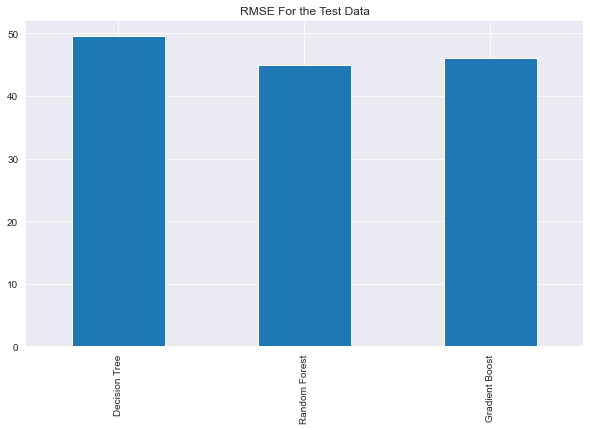

In [51]:
scores = pd.Series([rmse(y_test, tre_test),
                    rmse(y_test, for_test),
                    rmse(y_test, boo_test)],
                       index = ['Decision Tree', 'Random Forest', 'Gradient Boost'])

scores.plot(kind = 'bar', figsize = (10,6), title = 'RMSE For the Test Data')
plt.show()

### Selected Model
- The random forest regressor, with 300 estimators and a maximum tree depth of 17, has the best RMSE on the test set.
- Its RMSE is 44.887.


# Conclusion
For the task of predicting the number of taxis that will be ordered one hour ahead of time, I've analysed the data, created features, and tuned hyperparameters.

- I've resapled the data to be hourly, to assist model training later on.
- Analysis of the data was done with the help of the seasonal_decompose function from statsmodels library. In the analysis I've observed:
    - Cyclical, daily changes.
    - Trends that occur over a day or multiple days.
    - Trends that occur over weeks and months.
- Feature creation:
    - I've extracted from the datetime column three features: hour, day of week, and week of year.
    - I've shifted the target column to created two kinds of previous-taxi-counts, one for the hour before the prediction, and one for the day before the prediction on the same hour.
- I can recomend the use of a RandomForestRegressor algorithm to predict for this task, with the hyperparameters being 'max_depth': 17 and 'n_estimators': 300.